In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

processed = Path("../data/processed")
datafile = processed / "whatsapp-20240214-112323.parq"
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")

In [3]:
df = pd.read_parquet(datafile)
df

,timestamp,author,message,has_emoji,message_length,has_link,hour,day_of_week
0,2017-03-05 15:08:00,Unknown,05-03-2017 15:08 - ‎Bryan Zaagsma heeft de gro...,True,70,False,15:08:00,6
1,2018-05-07 08:09:00,Unknown,07-05-2018 08:09 - ‎Bryan Zaagsma heeft u toeg...,False,53,False,08:09:00,0
2,2018-05-07 08:13:00,Justin Velthuijsen,2\n,False,3,False,08:13:00,0
3,2018-05-07 08:14:00,Kerim Ozel,3\n,False,3,False,08:14:00,0
4,2018-05-07 08:20:00,Stephan van den Hoogen,4\n,False,3,False,08:20:00,0
...,...,...,...,...,...,...,...,...
7241,2024-02-09 23:24:00,Unknown,09-02-2024 23:24 - ‎Bryan Zaagsma heeft een be...,False,62,False,23:24:00,4
7242,2024-02-10 13:38:00,Falco,"Nee joh, ik moet aan het werk\n",False,31,False,13:38:00,5
7243,2024-02-10 13:38:00,Falco,"Jammer, mannen\n",False,16,False,13:38:00,5
7244,2024-02-10 13:39:00,Bryan Zaagsma,Zeker! Volgende week is Kay er niet dus ga er...,False,51,False,13:39:00,5


Let's extract some more info from the timestamp:

In [4]:
df["date"] = df["timestamp"].dt.date
df["isoweek"] = df["timestamp"].dt.isocalendar().week
df.head()


,timestamp,author,message,has_emoji,message_length,has_link,hour,day_of_week,date,isoweek
0,2017-03-05 15:08:00,Unknown,05-03-2017 15:08 - ‎Bryan Zaagsma heeft de gro...,True,70,False,15:08:00,6,2017-03-05,9
1,2018-05-07 08:09:00,Unknown,07-05-2018 08:09 - ‎Bryan Zaagsma heeft u toeg...,False,53,False,08:09:00,0,2018-05-07,19
2,2018-05-07 08:13:00,Justin Velthuijsen,2\n,False,3,False,08:13:00,0,2018-05-07,19
3,2018-05-07 08:14:00,Kerim Ozel,3\n,False,3,False,08:14:00,0,2018-05-07,19
4,2018-05-07 08:20:00,Stephan van den Hoogen,4\n,False,3,False,08:20:00,0,2018-05-07,19


Now, we can group by the isoweeks, for example. 
Let's reindex in order to fill the missing weeks.

In [5]:
p = df.groupby("isoweek").count()
p.head()

,timestamp,author,message,has_emoji,message_length,has_link,hour,day_of_week,date
isoweek,,,,,,,,,
2,52,52,52,52,52,52,52,52,52
3,189,189,189,189,189,189,189,189,189
4,132,132,132,132,132,132,132,132,132
5,130,130,130,130,130,130,130,130,130
6,186,186,186,186,186,186,186,186,186


<Axes: xlabel='isoweek', ylabel='timestamp'>

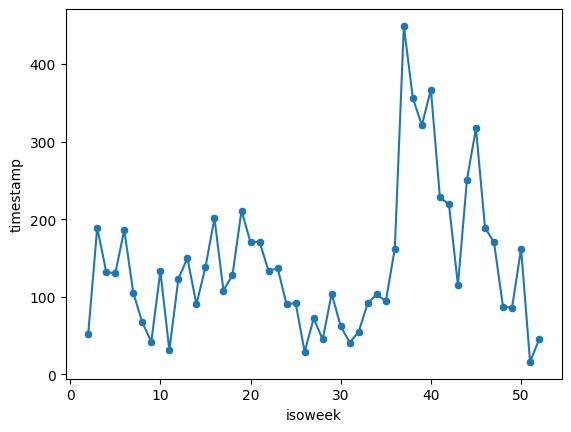

In [6]:
# lets reindex the isoweeks. This wont work if you have multiple years!
p = p.reindex(range(int(p.index.min()), int(p.index.max()) + 1), fill_value=0)
sns.scatterplot(data=p, x="isoweek", y="timestamp")
sns.lineplot(data=p, x="isoweek", y="timestamp")

Try to play with the colors. Make sure adding colors conveys a message, and isnt randomly adding colors.

<Axes: xlabel='isoweek', ylabel='timestamp'>

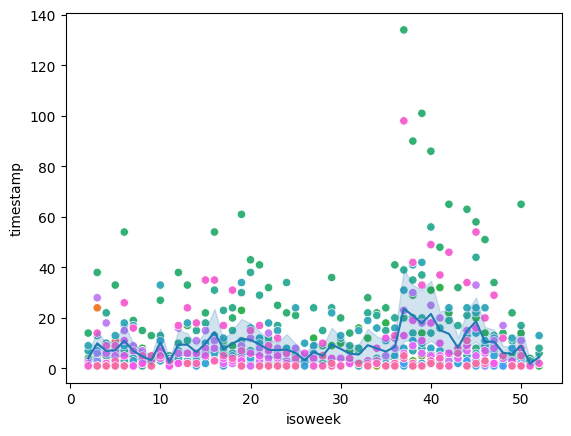

In [7]:
p = df.groupby(["author", "isoweek"]).count()
sns.scatterplot(data=p, x="isoweek", y="timestamp", hue="author", legend=False)
sns.lineplot(data=p, x="isoweek", y="timestamp", legend=False)

In [8]:
df = pd.read_parquet(datafile)
df["date"] = df["timestamp"].dt.date
df["day_of_week"] = df["timestamp"].dt.day_name()
df_agg = df.groupby(['date', 'day_of_week']).size().reset_index(name='message_count')
df_agg

,date,day_of_week,message_count
0,2017-03-05,Sunday,1
1,2018-05-07,Monday,20
2,2018-05-08,Tuesday,26
3,2018-05-14,Monday,7
4,2018-05-15,Tuesday,6
...,...,...,...
491,2024-02-06,Tuesday,22
492,2024-02-07,Wednesday,2
493,2024-02-08,Thursday,4
494,2024-02-09,Friday,65


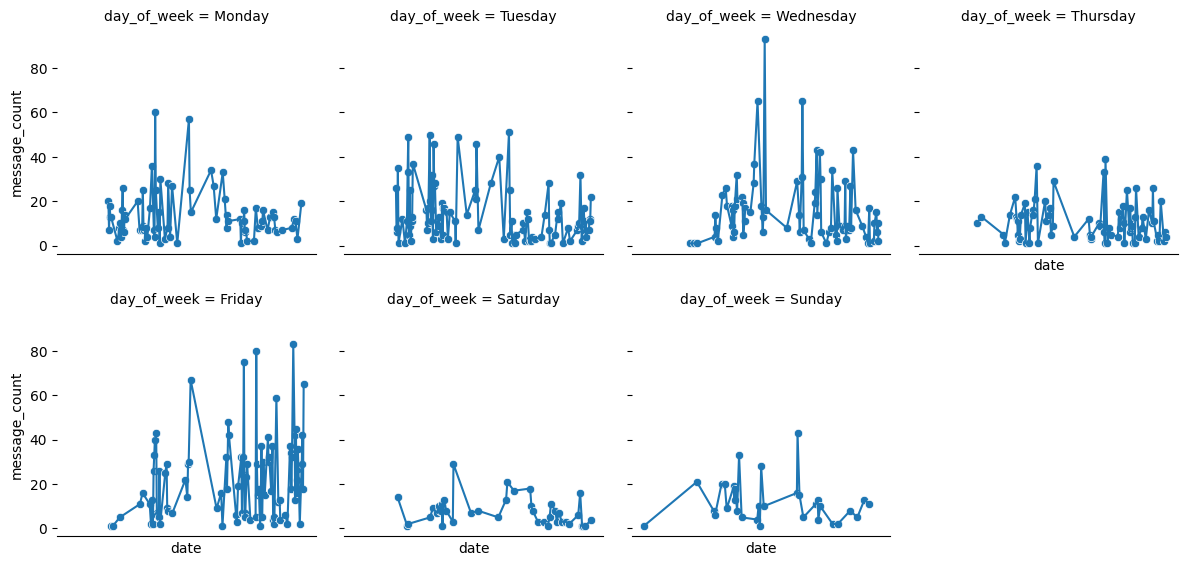

In [9]:

# Set the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a FacetGrid to plot the line plots for each day of the week
g = sns.FacetGrid(df_agg, col='day_of_week', col_wrap=4, height=3, col_order=days_order)
g.map(sns.scatterplot, 'date', 'message_count')
g.map(sns.lineplot, 'date', 'message_count')
g.set(xticks=[])
g.despine(left=True, bottom=False)

In [10]:
df.head()

,timestamp,author,message,has_emoji,message_length,has_link,hour,day_of_week,date
0,2017-03-05 15:08:00,Unknown,05-03-2017 15:08 - ‎Bryan Zaagsma heeft de gro...,True,70,False,15:08:00,Sunday,2017-03-05
1,2018-05-07 08:09:00,Unknown,07-05-2018 08:09 - ‎Bryan Zaagsma heeft u toeg...,False,53,False,08:09:00,Monday,2018-05-07
2,2018-05-07 08:13:00,Justin Velthuijsen,2\n,False,3,False,08:13:00,Monday,2018-05-07
3,2018-05-07 08:14:00,Kerim Ozel,3\n,False,3,False,08:14:00,Monday,2018-05-07
4,2018-05-07 08:20:00,Stephan van den Hoogen,4\n,False,3,False,08:20:00,Monday,2018-05-07


In [11]:
import plotly.express as px
# first count the number for every category, for every date
p = df.groupby(["date", "timestamp_category"]).size().reset_index(name='message_count')
# then, make the count cumulative for every category
p['cumulative_count'] = p.groupby('timestamp_category')['message_count'].cumsum()

fig = px.area(p, x="date", y="cumulative_count", color="timestamp_category",
              line_group="timestamp_category", labels={"cumulative_count": "Cumulative Message Count"})
fig.show()

KeyError: 'timestamp_category'